<span style="font-size:50px"><strong>ML4HC Project 1 - Task 2</strong></span>


#  Classic Machine Learning Methods - Q2.1

Transform time series data to simple value per patient

In [107]:
def transform_time_series_to_vector(df, trafo_function="mean"):
    df = df.drop(columns=["ICUType"])

    static_vars = ['Age', 'Gender', 'Height']
    ts_vars = [col for col in df.columns if col not in static_vars + ['RecordID', 'Time']]

    if trafo_function == "mean":
        ts_df = df.groupby('RecordID')[ts_vars].mean()
    elif trafo_function == "max":
        ts_df = df.groupby('RecordID')[ts_vars].max()
    elif trafo_function == "last_measured":
        ts_df = df.sort_values("Time").groupby('RecordID')[ts_vars].last()
    else:
        raise ValueError("Invalid trafo_function")

    static_df = df.groupby('RecordID')[static_vars].first()
    return pd.concat([static_df, ts_df], axis=1)


Get Training , Validation or Test Data

In [115]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")
    df = transform_time_series_to_vector(df, trafo_function="mean")
    y = df["In-hospital_death"]
    X = df.drop(columns=["In-hospital_death"])
    return X, y


In [127]:
X_train,y_train =get_data("train")
print(y.shape)
print(X.shape)
#X.head()

(4000,)
(4000, 39)


### Train Model

Training function

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train_and_evaluate_model(model, split="val"):

    X_train,y_train =get_data("train")

    model.fit(X_train, y_train)

    X_evaluate,y_evaluate =get_data(split)

    y_pred = model.predict_proba(X_evaluate)[:, 1]

    auroc = roc_auc_score(y_evaluate, y_pred)
    auprc = average_precision_score(y_evaluate, y_pred)

    print("AUROC:", auroc)
    print("AUPRC:", auprc)


###  Test models

In [128]:
from sklearn.linear_model import LogisticRegression

model_log_reg = LogisticRegression(max_iter=1000)
train_and_evaluate_model(model_log_reg, split="test")

AUROC: 0.809153182915994
AUPRC: 0.4394604706371753


In [129]:
from sklearn.ensemble import RandomForestClassifier

model_rand_forest = RandomForestClassifier(n_estimators=100, random_state=0)
train_and_evaluate_model(model_rand_forest, split="test")


AUROC: 0.8050513696487344
AUPRC: 0.43799286782678326


In [130]:
from sklearn.svm import SVC

model_svm = SVC(probability=True)
train_and_evaluate_model(model_svm, split="test")


AUROC: 0.7680189210496676
AUPRC: 0.3917599205717994


In [131]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(model_knn, split="test")


AUROC: 0.6610887111912003
AUPRC: 0.24354811767704038


In [132]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()
train_and_evaluate_model(model_gb, split="test")


AUROC: 0.8121089712304941
AUPRC: 0.43910958541906464


In [133]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
train_and_evaluate_model(model_nb, split="test")


AUROC: 0.7445948617837344
AUPRC: 0.3158511164446923


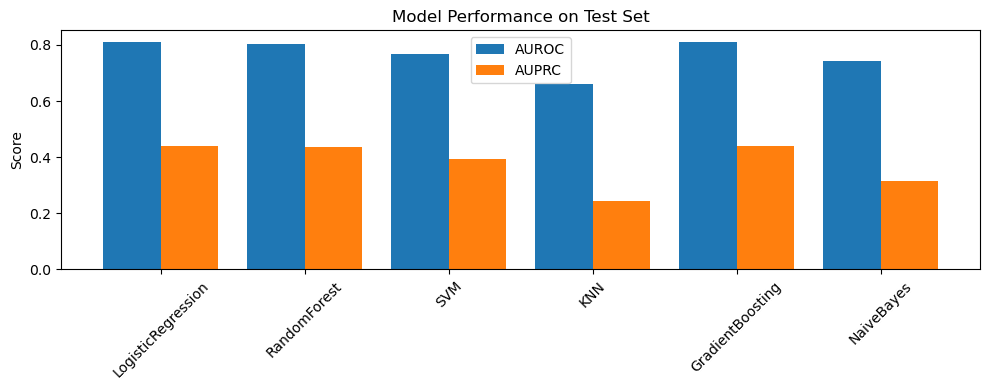

In [134]:
import matplotlib.pyplot as plt

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=0),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(),
    "NaiveBayes": GaussianNB()
}

results = {"Model": [], "AUROC": [], "AUPRC": []}

for name, model in models.items():
    X_train, y_train = get_data("train")
    X_test, y_test = get_data("test")

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred)

    results["Model"].append(name)
    results["AUROC"].append(auroc)
    results["AUPRC"].append(auprc)

# Plotting
x = range(len(results["Model"]))
plt.figure(figsize=(10, 4))

plt.bar(x, results["AUROC"], width=0.4, label="AUROC", align='center')
plt.bar([i + 0.4 for i in x], results["AUPRC"], width=0.4, label="AUPRC", align='center')
plt.xticks([i + 0.2 for i in x], results["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Model Performance on Test Set")
plt.legend()
plt.tight_layout()
plt.show()


# Recurrent Neural Networks - Q2-2

this is random chatgpt code just to have a look, likely best do everything again

In [141]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score

# Adjust this based on your time series structure
TIME_COLUMN = "Time"
ID_COLUMN = "RecordID"

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len=48):
        self.seq_len = seq_len
        self.samples = []
        self.labels = []
        for rid, group in df.groupby(ID_COLUMN):
            group = group.sort_values(TIME_COLUMN)
            X = group.drop(columns=["In-hospital_death", ID_COLUMN, TIME_COLUMN]).to_numpy()
            y = group["In-hospital_death"].iloc[0]
            # pad or truncate to fixed length
            if len(X) < seq_len:
                pad = np.zeros((seq_len - len(X), X.shape[1]))
                X = np.vstack([pad, X])
            else:
                X = X[-seq_len:]
            self.samples.append(X)
            self.labels.append(y)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.squeeze(1)

def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    return pd.read_parquet(f"data_{letter}_scaled.parquet")

def train_and_evaluate_lstm(model, split="val", batch_size=64, epochs=10, lr=1e-3):
    train_df = get_data("train")
    val_df = get_data(split)

    train_ds = TimeSeriesDataset(train_df)
    val_ds = TimeSeriesDataset(val_df)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(probs)

    auroc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)

    print("AUROC:", auroc)
    print("AUPRC:", auprc)

# Usage
input_size = get_data("train").drop(columns=["In-hospital_death", "RecordID", "Time"]).shape[1]
model = LSTMClassifier(input_size=input_size)
train_and_evaluate_lstm(model, split="test")


AUROC: 0.7997322020748082
AUPRC: 0.4549753646368854
